In [1]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
import random

In [2]:
# -------------------------
# DATA PREPARATION
# -------------------------

# Ensure folders exist
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

for path in ['/train', '/test', '/val']:
    for dirname, _, filenames in os.walk(base_path + path):
        for i, file in enumerate(filenames):
            img_class = dirname.split('/')[6]
            copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

for dirname, _, filenames in os.walk('images'):
    if len(dirname.split("/")) > 1:
        print(f"{dirname} has {len(filenames)} files")

# Train-test split
os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), test_size=0.2, random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL', img), os.path.join('train/NORMAL', img))
for img in test:
    copyfile(os.path.join('images/NORMAL', img), os.path.join('test/NORMAL', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), test_size=0.2, random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA', img), os.path.join('train/PNEUMONIA', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA', img), os.path.join('test/PNEUMONIA', img))

images/NORMAL has 1583 files
images/PNEUMONIA has 4273 files


In [3]:
# -------------------------
# DATA PREPARATION
# -------------------------

# Ensure folders exist
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

for path in ['/train', '/test', '/val']:
    for dirname, _, filenames in os.walk(base_path + path):
        for i, file in enumerate(filenames):
            img_class = dirname.split('/')[6]
            copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

for dirname, _, filenames in os.walk('images'):
    if len(dirname.split("/")) > 1:
        print(f"{dirname} has {len(filenames)} files")

# Train-test split
os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), test_size=0.2, random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL', img), os.path.join('train/NORMAL', img))
for img in test:
    copyfile(os.path.join('images/NORMAL', img), os.path.join('test/NORMAL', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), test_size=0.2, random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA', img), os.path.join('train/PNEUMONIA', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA', img), os.path.join('test/PNEUMONIA', img))

images/NORMAL has 1583 files
images/PNEUMONIA has 4273 files


In [5]:
# -------------------------
# VGG16 MODEL SETUP
# -------------------------
SIZE = 128 
# Load the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base layers (optional for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

# Compile the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision()]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
SIZE = 128  # Image size for resizing
BATCH = 64  # Batch size

# Image augmentation
image_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=5,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               validation_split=0.2)

# Flow_from_directory generators for training and validation data
train_generator = image_gen.flow_from_directory(
    'train',  # Directory for training images
    target_size=(SIZE, SIZE),  # Resize images to SIZE x SIZE
    class_mode="binary",  # Binary classification (normal vs pneumonia)
    batch_size=BATCH,
    subset='training'  # Use subset for training data
)

validation_generator = image_gen.flow_from_directory(
    'train',  # Directory for training images
    target_size=(SIZE, SIZE),  # Resize images to SIZE x SIZE
    class_mode="binary",  # Binary classification (normal vs pneumonia)
    batch_size=BATCH,
    subset='validation'  # Use subset for validation data
)


Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.


In [11]:
# -------------------------
# TRAINING
# -------------------------

# Callbacks
mc = ModelCheckpoint('vgg_model.keras', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

model_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.n // BATCH,
    validation_steps=validation_generator.n // BATCH,
    epochs=15,
    verbose=1,
    callbacks=[mc, rlr]
)


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733200784.453613      94 service.cc:145] XLA service 0x7fc650007270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733200784.453692      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/58 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2812 - loss: 0.7745 - precision: 0.2069 - recall: 0.0690          

I0000 00:00:1733200791.687956      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 823ms/step - accuracy: 0.6704 - loss: 0.5817 - precision: 0.7052 - recall: 0.8790 - val_accuracy: 0.8158 - val_loss: 0.3706 - val_precision: 0.8101 - val_recall: 0.9771 - learning_rate: 0.0010
Epoch 2/15
 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8750 - loss: 0.3214 - precision: 0.8772 - recall: 0.9804

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8750 - loss: 0.3214 - precision: 0.8772 - recall: 0.9804 - val_accuracy: 0.8500 - val_loss: 0.2875 - val_precision: 0.8235 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 730ms/step - accuracy: 0.8623 - loss: 0.3232 - precision: 0.8681 - recall: 0.9562 - val_accuracy: 0.8839 - val_loss: 0.2649 - val_precision: 0.9193 - val_recall: 0.9221 - learning_rate: 0.0010
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8056 - loss: 0.4060 - precision: 0.8400 - recall: 0.8750 - val_accuracy: 0.9250 - val_loss: 0.2120 - val_precision: 0.9310 - val_recall: 0.9643 - learning_rate: 0.0010
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 728ms/step - accuracy: 0.9034 - loss: 0.2415 - precision: 0.9243 - recall: 0.9455 - val_accuracy: 0.9107 - val_loss: 0.2176 - val_precision: 0.9366 - val_recall: 0.9422 - learning_rate: 0.0010
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss:

In [14]:
# Load the best model
model.load_weights('vgg_model.keras')


Found 1172 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 517ms/step


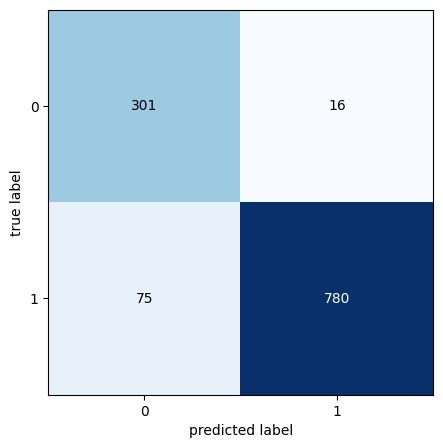

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       317
           1       0.98      0.91      0.94       855

    accuracy                           0.92      1172
   macro avg       0.89      0.93      0.91      1172
weighted avg       0.93      0.92      0.92      1172



In [15]:
# -------------------------
# TESTING
# -------------------------

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory="test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

# Predictions and evaluation
preds = model.predict(test_generator)
labels = (preds > 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5, 5))
plt.show()

print(classification_report(test_generator.classes, labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


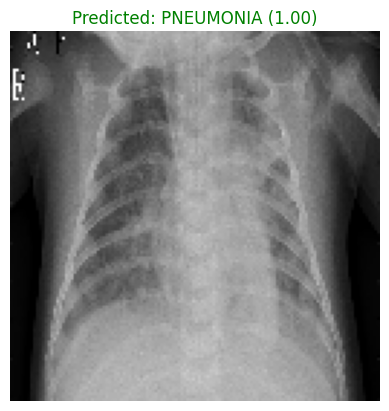

Image: /kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
Predicted Class: PNEUMONIA
Confidence Score: 1.00


In [22]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(SIZE, SIZE))  # Resize image to match model input
    img_array = img_to_array(img) / 255.0  # Scale pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_array)[0][0]
    predicted_class = class_labels[int(prediction > 0.5)]  # Convert to class label

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({prediction:.2f})", color="green" if prediction > 0.5 else "red")
    plt.show()

    # Print prediction result
    print(f"Image: {image_path}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {prediction:.2f}")

# Define the class labels (NORMAL and PNEUMONIA in this case)
class_labels = list(test_generator.class_indices.keys())

# Path to the image to predict
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"  # Replace with your image path

# Call the function
predict_single_image(model, image_path, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


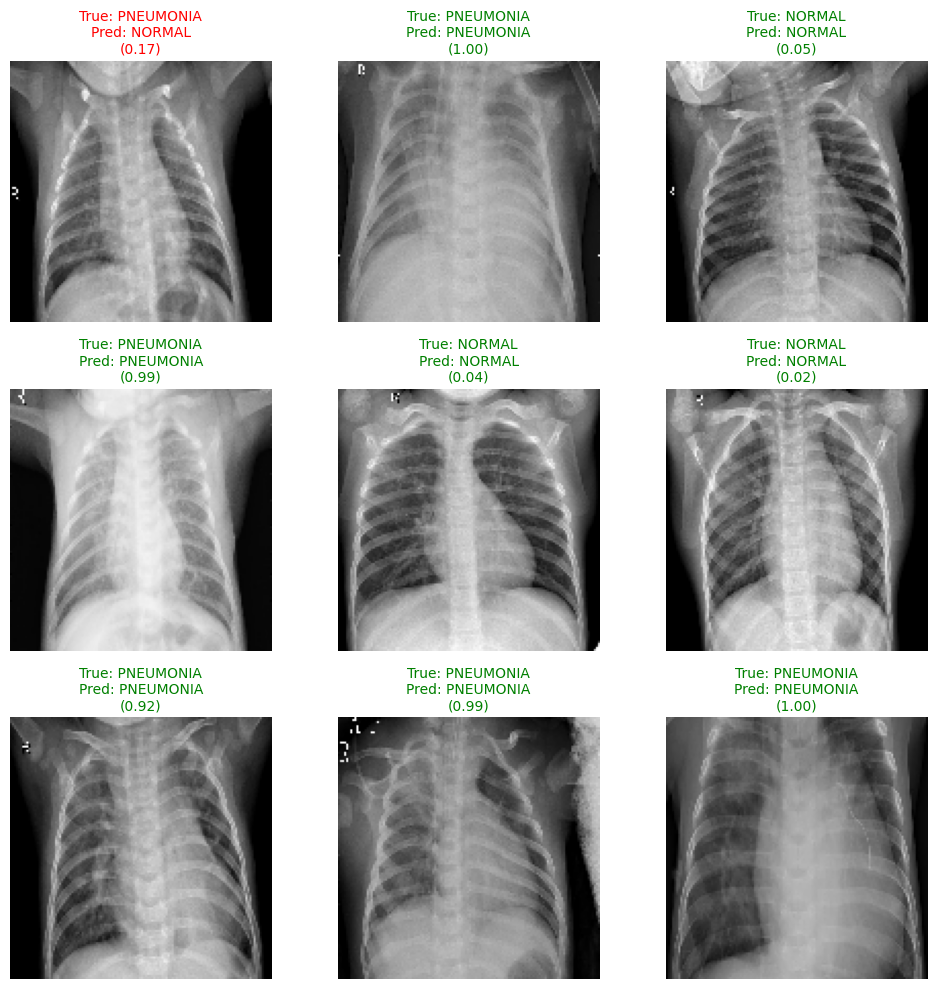

In [23]:
# -------------------------
# DISPLAY RANDOM IMAGES WITH PREDICTIONS
# -------------------------

def predict_and_display_grid_with_true_labels(model, directory, class_labels, grid_size=(3, 3)):
    images = []
    true_labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg')):
                    images.append(os.path.join(class_path, file))
                    true_labels.append(class_folder)

    selected_images = random.sample(range(len(images)), grid_size[0] * grid_size[1])
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten()

    for idx, img_idx in enumerate(selected_images):
        image_path = images[img_idx]
        true_label = true_labels[img_idx]

        img = load_img(image_path, target_size=(SIZE, SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = class_labels[int(prediction > 0.5)]

        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"True: {true_label}\nPred: {predicted_class}\n({prediction:.2f})",
                            fontsize=10,
                            color="green" if true_label == predicted_class else "red")

    for i in range(len(selected_images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

class_labels = list(test_generator.class_indices.keys())
predict_and_display_grid_with_true_labels(model, "/kaggle/input/chest-xray-pneumonia/chest_xray/train", class_labels, grid_size=(3, 3))